In [ ]:
GOOGLE_CSE_API_KEY = input("Enter GOOGLE CSE API KEY: ")

In [82]:
# IF THE "output.csv" FILE EXISTS, RUN THIS CELL AND THE LAST CELL
# UNLESS YOU WANT TO UPDATE THE DATA, THEN RUN ALL THE CELLS IN BETWEEN AS WELL, SEQUENTIALLY. EDIT THE CODE IF NEED BE


# IMPORTS & DEFINITIONS; variables and util functions

import requests
import json
import re
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import traceback
from threading import Thread
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures


TOTAL_AVAILABLE_STUDIES = 382563
clinical_trials_api = {
    "full_studies": {
        "url": "https://clinicaltrials.gov/api/query/full_studies",
        "params": {
            "expr": "",
            "min_rnk": 1,
            "max_rnk": 100, # Only 100 studies are returned at a time, this can be combined with min_rnk to paginate
            "fmt": "json"
        }
    },
    # "study_fields_list": {
    #     "url": "https://clinicaltrials.gov/api/info/study_fields_list",
    #     "params": {
    #         "fmt": "json"
    #     }
    # },
    # "study_fields": {
    #
    #     "url": "https://clinicaltrials.gov/api/query/study_fields",
    #     "params": {
    #         "expr": "",
    #         "fmt": "json"
    #     }
    # }
}


def googlesearch(query):
    google_cse_api_key = GOOGLE_CSE_API_KEY
    cse_id = "15ed706f6b763cb8c"
    res = requests.get('https://customsearch.googleapis.com/customsearch/v1/siterestrict', params={'cx': cse_id, 'q': query, 'key': google_cse_api_key, 'num': 1})
    json_response = res.json()
    return json_response


def get_response_rate(text):
    response_rate = re.findall(r'response .+[0-9]+%', text)
    if len(response_rate)>0:
        response_rate = re.findall(r'[0-9]*\.*[0-9]+%', response_rate[0])
        response_rate = response_rate[0]
    else:
        response_rate = "unknown"
    return response_rate


def get_survival_rate(text):
    survival_rate = re.findall(r'survival .+[0-9]*\.*[0-9]+ *months', text)
    if len(survival_rate)>0:
        survival_rate = re.findall(r'[0-9]*\.*[0-9]+ months', survival_rate[0])
        try:
            survival_rate = str(max([float(i.split(' ')[0]) for i in survival_rate]))
        except:
            survival_rate = "unknown"
    else:
        survival_rate = "unknown"
    return survival_rate


def get_study_data(study):
    intervention = study.get("Study", {}).get("ProtocolSection", {}).get("ArmsInterventionsModule", {}).get("InterventionList", {}).get("Intervention")
    we_want_this_study = False
    if type(intervention) == list and len(intervention) > 0:
        for intv in intervention:
            if intv["InterventionType"] == "Drug":
                we_want_this_study = True
                break

    if we_want_this_study:
        drug_interventions = []
        drug_interventions_with_response_rate = []
        for intervention in study.get("Study", {}).get("ProtocolSection", {}).get("ArmsInterventionsModule", {}).get("InterventionList", {}).get("Intervention"):
            if intervention["InterventionType"] == "Drug":
                drug_interventions.append(intervention)
        data = {
            "BriefTitle": study.get("Study", {}).get("ProtocolSection", {}).get("IdentificationModule", {}).get("BriefTitle", {}),
            #"OfficialTitle": study.get("Study", {}).get("ProtocolSection", {}).get("IdentificationModule", {}).get("OfficialTitle", {}),
            "StartDate": study.get("Study", {}).get("ProtocolSection", {}).get("StatusModule", {}).get("StartDateStruct", {}).get("StartDate"),
            "CompletionDate": study.get("Study", {}).get("ProtocolSection", {}).get("StatusModule", {}).get("CompletionDateStruct", {}).get("CompletionDate"),
            "OverallStatus": study.get("Study", {}).get("ProtocolSection", {}).get("StatusModule", {}).get("OverallStatus", {}),
            "EnrollmentCount": study.get("Study", {}).get("ProtocolSection", {}).get("DesignModule", {}).get("EnrollmentInfo", {}).get("EnrollmentCount"),
            "Condition": study.get("Study", {}).get("ProtocolSection", {}).get("ConditionsModule", {}).get("ConditionList", {}).get("Condition", [""])[0],
            "Interventions": drug_interventions,
            #"ArmGroup": study.get("Study", {}).get("ProtocolSection", {}).get("ArmsInterventionsModule", {}).get("ArmGroupList", {}).get("ArmGroup"),
            #"BriefSummary": study.get("Study", {}).get("ProtocolSection", {}).get("DescriptionModule", {}).get("BriefSummary", {}),
        }
        number_of_unknown_response_rates = 0
        for intervention in data["Interventions"]:
            intervention_has_response_rate = False
            drug = intervention["InterventionName"]
            condition = data["Condition"]
            response_rate_query = 'response rate {drug} in "{condition}"'.format(drug=drug, condition=condition[0])
            survival_rate_query = 'survival months {drug} in "{condition}"'.format(drug=drug, condition=condition[0])
            response_rate_search_result = googlesearch(response_rate_query)
            survival_rate_search_result = googlesearch(survival_rate_query)

            for item in  response_rate_search_result.get("items", [{}]):
                response_rate = get_response_rate(item.get("snippet", ""))
                intervention["response_rate"] = response_rate
                if response_rate == 'unknown':
                    continue
                else:
                    intervention_has_response_rate = True
                    intervention["response_rate_source"] = item.get("link", "")
                    intervention["response_rate_snippet"] = item.get("snippet", "")
                    break

            for item in  survival_rate_search_result.get("items", [{}]):
                survival_rate = get_survival_rate(item.get("snippet", ""))
                intervention["survival_rate"] = survival_rate
                if survival_rate == 'unknown':
                    continue
                else:
                    intervention["survival_rate_source"] = item.get("link", "")
                    intervention["survival_rate_snippet"] = item.get("snippet", "")
                    break

            if intervention_has_response_rate:
                drug_interventions_with_response_rate.append(intervention)
            else:
                number_of_unknown_response_rates+=1

        if number_of_unknown_response_rates == len(data["Interventions"]):
            return None
        else:
            data["Interventions"] = drug_interventions_with_response_rate
        return data

    return None


def csv_to_dict(file_path):
    return pd.read_csv(file_path).to_dict()


def update_dict_with_response_survival_data(data_dict, cancer_index, max_survival, max_response):
    data_dict["max_survival"][cancer_index] = max_survival
    data_dict["max_response"][cancer_index] = max_response
    return data_dict

In [ ]:
# GET CLINICAL TRIALS DATA OF CANCERS IN DALY DATA CSV

daly_data = csv_to_dict('daly_data.csv')
daly_data["max_survival"] = {}
daly_data["max_response"] = {}
# print(json.dumps(daly_data, indent=4, sort_keys=False))
c_index = 0
count = 0
daly_data["max_survival"] = {}
daly_data["max_response"] = {}
for item in daly_data["Cause_Name_Label"]:
# for item in range(4):
    count += 1
    print('{}/{} - Getting data for '.format(count, len(daly_data["Cause_Name_Label"]))+ daly_data["Cause_Name_Label"][item] + " cancer")

    c_index = item # cancer index
    clinical_trials_api["full_studies"]["params"]["expr"] = daly_data["Cause_Name_Label"][item] + " cancer"

    results = requests.get(clinical_trials_api["full_studies"]["url"], params=clinical_trials_api["full_studies"]["params"])
    results = results.json()
    studies = []
    futures = []
    mx_survival = 0
    mx_response = 0

    with ThreadPoolExecutor(max_workers=100) as executor:
        for study_ in results["FullStudiesResponse"]["FullStudies"]:
            futures.append(executor.submit(get_study_data, study_))

    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        if result is not None:
            for intervention in result["Interventions"]:
                if intervention["survival_rate"]!='unknown' and float(intervention["survival_rate"])>mx_survival:
                    mx_survival = float(intervention["survival_rate"])
                if intervention["response_rate"]!='unknown' and float(intervention["response_rate"].strip("%"))>mx_response:
                    mx_response = float(intervention["response_rate"].strip("%"))
                daly_data = update_dict_with_response_survival_data(daly_data, c_index, mx_survival, mx_response)
            # studies.append(result)
            print(json.dumps(result, indent=4, sort_keys=False))
    
    print()
    print()
    print()


df = pd.DataFrame.from_dict(daly_data)
df.to_csv("output.csv")
# print(json.dumps(daly_data, indent=4, sort_keys=False))



Getting data for Esophageal cancer
Getting data for Stomach cancer
Getting data for Liver cancer
Getting data for Tracheal, Bronchus & Lung cancer
Getting data for Breast cancer
Getting data for Cervical cancer
Getting data for Uterine cancer
Getting data for Prostate cancer
Getting data for Colorectal cancer
Getting data for Nasopharynx cancer
Getting data for Gallbladder & Biliary Tract cancer
Getting data for Pancreatic cancer
Getting data for Skin (Melanoma) cancer
Getting data for Ovarian cancer
Getting data for Kidney cancer
Getting data for Bladder cancer
Getting data for Brain & CNS cancer
Getting data for Thyroid cancer
Getting data for Mesothelioma cancer
Getting data for Hodgkin Lymphoma cancer


posx and posy should be finite values
posx and posy should be finite values


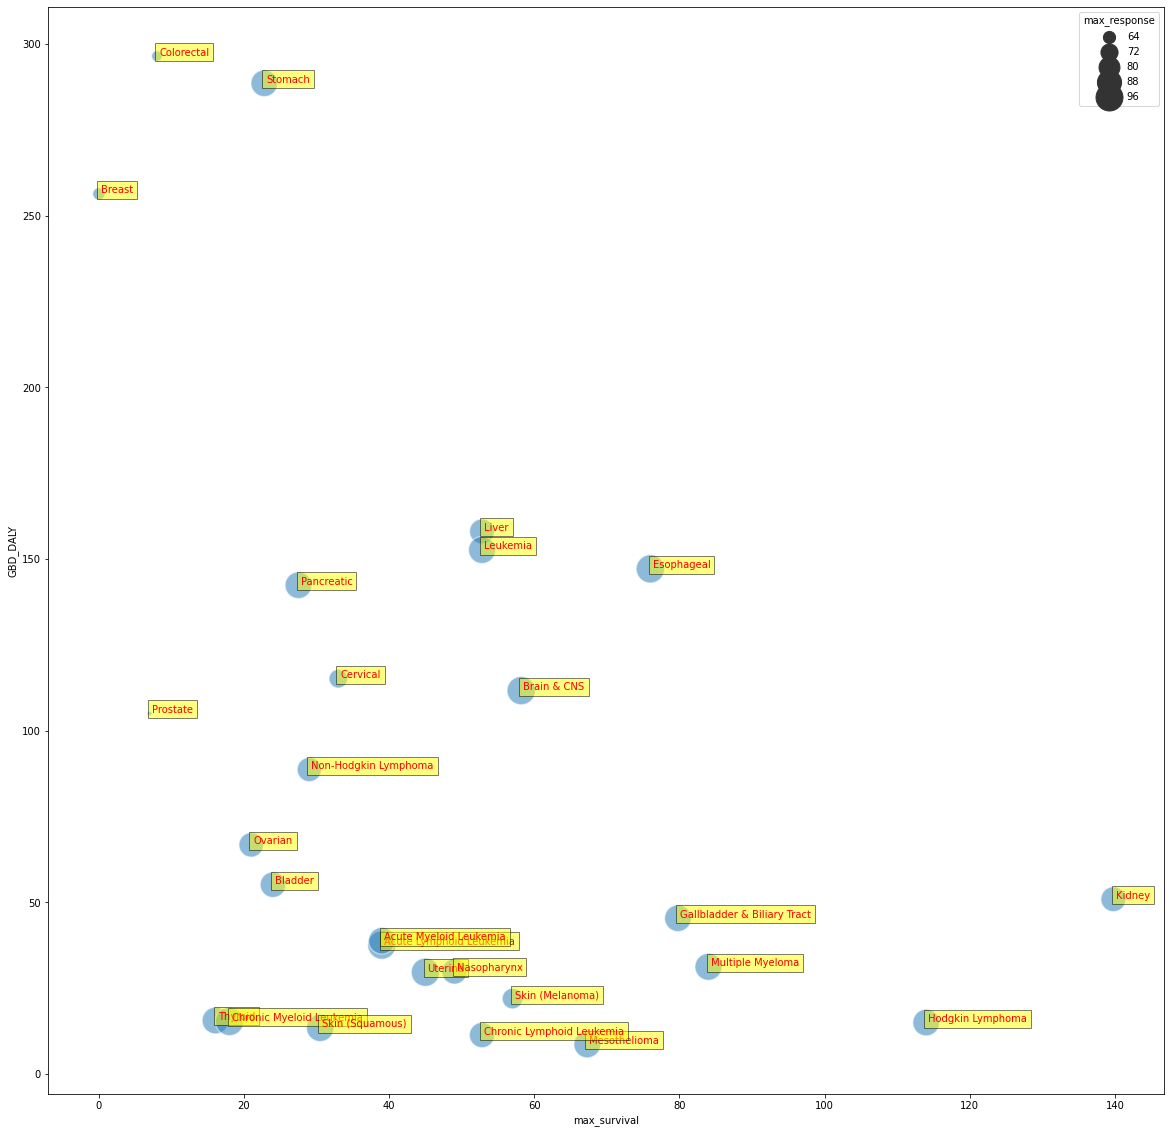

In [94]:
daly_data = csv_to_dict("output.csv")
# PLOT THE DATA
x = "max_survival"
y = "GBD_DALY"
z = "max_response"
# use the scatterplot function
plt.figure(figsize=(20, 14))
sns.scatterplot(data=daly_data, x=x, y=y, size=z, alpha=0.5, sizes=(20, 800))
for item in daly_data["Cause_Name_Label"]:
    plt.text(x=daly_data[x][item]+0.3,
             y=daly_data[y][item]+0.3,
             s=daly_data["Cause_Name_Label"][item],
             fontdict=dict(color='red',size=10),
             bbox=dict(facecolor='yellow',alpha=0.5))


# show the graph
plt.show()
